# Bayesian Optimiser (unlabelled) Example

This notebook contains an example of how the Bayesian Optimiser module can be used to optimise the thresholds of an existing set of rules, given an **unlabelled** dataset, using Bayesian Optimisation.

## Requirements

To run, you'll need the following:

* A rule set stored in the standard Iguanas lambda expression format, along with the keyword arguments for each lambda expression (more information on how to do this later)
* An unlabelled dataset containing the features present in the rule set.

----

## Import packages

In [1]:
from iguanas.rule_optimisation import BayesianOptimiser
from iguanas.rules import Rules
from iguanas.rule_application import RuleApplier
from iguanas.metrics.unsupervised import AlertsPerDay

import pandas as pd
from sklearn.model_selection import train_test_split
from hyperopt import tpe

ImportError: cannot import name 'AlertsPerDay' from 'iguanas.metrics.classification' (/Users/jlaidler/Documents/argo/iguanas/metrics/classification.py)

## Read in data

Firstly, we need to read in the raw data containing the features:

In [ ]:
data = pd.read_csv(
    'dummy_data/dummy_pipeline_output_data.csv', 
    index_col='eid'
)

Then we can split the dataset into training and test sets:

In [ ]:
X_train, X_test = train_test_split(
    data, 
    test_size=0.33, 
    random_state=0
)

## Read in the rules

In this example, we'll read in the rule conditions from a pickle file, where they are stored in the standard Iguanas string format. **However, you can use any Iguanas-ready rule format - see the example notebook in the *rules* module.**

In [ ]:
import pickle
with open('dummy_data/rule_strings.pkl', 'rb') as f:
    rule_strings = pickle.load(f)

Now we can instantiate the *Rules* class with these rules:

In [ ]:
rules = Rules(rule_strings=rule_strings)

We now need to convert the rules into the standard Iguanas lambda expression format. This format allows new threshold values to be injected into the rule condition before being evaluated - this is how the Bayesian Optimiser finds the optimal threshold values:

In [ ]:
rule_lambdas = rules.as_rule_lambdas(
    as_numpy=False, 
    with_kwargs=True
)

By converting the rule conditions to the standard Iguanas lambda expression format, we also generate a dictionary which gives the keyword arguments to each lambda expression (this dictionary is saved as the class attribute *lambda_kwargs*). Using these keyword arguments as inputs to the lambda expressions will convert them into the standard Iguanas string format.

----

## Optimise rules

### Set up class parameters

Now we can set our class parameters for the Bayesian Optimiser. Here we're using the *.fit()* method from the *AlertsPerDay* class, which calculates the negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged. This means that when the Bayesian Optimiser comes to maximise this metric, it will try to minimise the difference between the actual number of records flagged and the targetted number of records flagged.

See the *metrics.unsupervised* module for more information on additional optimisation functions that can be used on unlabelled datasets.

**Please see the class docstring for more information on each parameter.**

In [ ]:
apd = AlertsPerDay(
    n_alerts_expected_per_day=10, 
    no_of_days_in_file=10
)

In [ ]:
params = {
    'rule_lambdas': rule_lambdas,
    'lambda_kwargs': rules.lambda_kwargs,
    'opt_func': apd.fit,
    'n_iter': 30,
    'algorithm': tpe.suggest,
    'num_cores': 1,
    'verbose': 1,
}

### Instantiate class and run fit method

Once the parameters have been set, we can run the *.fit()* method to optimise the rules.

In [ ]:
ro = BayesianOptimiser(**params)
X_rules = ro.fit(X=X_train)

--- Checking for rules with features that are missing in `X` ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 118765.69it/s]
--- Checking for rules that exclusively contain non-optimisable conditions ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 115831.07it/s]
--- Checking for rules that exclusively contain zero-variance features ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237885.90it/s]
--- Optimising rules ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.91it/s]


### Outputs

The *.fit()* method returns a dataframe giving the binary columns of the optimised rules as applied to the training dataset. It also creates the following attributes:

* rule_strings (dict): The optimised rules stored in the standard Iguanas string format (values) and their names (keys).
* rule_descriptions (pd.Dataframe): A dataframe showing the logic of the rules and their performance metrics on the training dataset.
* rule_names_missing_features (list): Names of rules which use features that are not present in the dataset (and therefore can't be optimised or applied).
* rule_names_no_opt_conditions (list): Names of rules which have no optimisable conditions (e.g.rules that only contain string-based conditions).
* rule_names_zero_var_features (list): Names of rules which exclusively contain zero variance features (based on `X`), so cannot be optimised.
* opt_rule_performances (dict): The optimisation metric (values) calculated for each optimised rule (keys) on the training set.
* orig_rule_performances (dict): The optimisation metric (values) calculated for each original rule (keys) on the training set.
* non_optimisable_rules (Rules): A `Rules` object containing the rules which could not be optimised.

In [ ]:
X_rules.head()

Rule                 RGDT_Rule81  RGDT_Rule24  RGDT_Rule137  RGDT_Rule263  \
eid                                                                         
503-0182982-0226911            1            1             0             1   
516-2441570-6696110            0            0             0             0   
475-5982298-4197297            0            0             0             0   
935-3613661-7862154            0            0             0             0   
936-1684183-4550418            0            0             0             0   

Rule                 RGDT_Rule272  ComplicatedRule  RGDT_Rule256  \
eid                                                                
503-0182982-0226911             0                0             1   
516-2441570-6696110             0                0             0   
475-5982298-4197297             0                0             0   
935-3613661-7862154             0                0             0   
936-1684183-4550418             0                0             0   

Rule                 RGDT_Rule162  RGDT_Rule35  RGDT_Rule2  RGDT_Rule313  \
eid                                                                        
503-0182982-0226911             1            1           1             1   
516-2441570-6696110             0            0           0             0   
475-5982298-4197297             0            0           0             0   
935-3613661-7862154             0            0           0             0   
936-1684183-4550418             0            0           0             0   

Rule                 RGDT_Rule193  RGDT_Rule112  RGDT_Rule195  RGDT_Rule45  \
eid                                                                          
503-0182982-0226911             0             0             0            0   
516-2441570-6696110             0             0             0            0   
475-5982298-4197297             0             0             0            0   
935-3613661-7862154             0             0             0            0   
936-1684183-4550418             0             0             0            0   

Rule                 RGDT_Rule153  HighFraudTxnPerAccountNum  RGDT_Rule241  \
eid                                                                          
503-0182982-0226911             0                          0             0   
516-2441570-6696110             0                          0             0   
475-5982298-4197297             0                          0             0   
935-3613661-7862154             0                          0             0   
936-1684183-4550418             0                          0             0   

Rule                 RGDT_Rule65  
eid                               
503-0182982-0226911            0  
516-2441570-6696110            0  
475-5982298-4197297            0  
935-3613661-7862154            0  
936-1684183-4550418            0

In [ ]:
ro.rule_strings

{'RGDT_Rule137': "((X['account_number_avg_order_total_per_account_number_7day']<=235.77924922263912)|(X['account_number_avg_order_total_per_account_number_7day'].isna()))&(X['account_number_num_fraud_transactions_per_account_number_1day']>=1)&(X['account_number_num_fraud_transactions_per_account_number_90day']>=1)&((X['account_number_sum_order_total_per_account_number_1day']<=3273.978958931867)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'RGDT_Rule81': "(X['account_number_avg_order_total_per_account_number_1day']>729.0157066766448)&(X['account_number_num_fraud_transactions_per_account_number_lifetime']>=0)&((X['account_number_num_order_items_per_account_number_30day']<=5)|(X['account_number_num_order_items_per_account_number_30day'].isna()))&((X['account_number_sum_order_total_per_account_number_1day']<=2496.2529968931435)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'HighFraudTxnPerAccountNum': "(X['account_number_num_fraud_tran

In [ ]:
ro.rule_descriptions.head()

PercDataFlagged  OptMetric  \
Rule                                       
RGDT_Rule81          0.011131      -0.01   
RGDT_Rule24          0.011019      -0.04   
RGDT_Rule137         0.011581      -0.09   
RGDT_Rule263         0.010569      -0.36   
RGDT_Rule272         0.010344      -0.64   

                                                          Logic  nConditions  
Rule                                                                          
RGDT_Rule81   (X['account_number_avg_order_total_per_account...            6  
RGDT_Rule24   (X['account_number_avg_order_total_per_account...            6  
RGDT_Rule137  ((X['account_number_avg_order_total_per_accoun...            6  
RGDT_Rule263  (X['account_number_num_fraud_transactions_per_...            6  
RGDT_Rule272  ((X['account_number_avg_order_total_per_accoun...            5

In [ ]:
ro.opt_rule_performances

{'RGDT_Rule81': -0.009999999999999929,
 'RGDT_Rule24': -0.039999999999999716,
 'RGDT_Rule137': -0.09000000000000043,
 'RGDT_Rule263': -0.3599999999999996,
 'RGDT_Rule272': -0.6400000000000011,
 'ComplicatedRule': -1.0,
 'RGDT_Rule256': -1.0,
 'RGDT_Rule162': -3.2400000000000024,
 'RGDT_Rule35': -7.290000000000001,
 'RGDT_Rule2': -12.25,
 'RGDT_Rule313': -22.090000000000003,
 'RGDT_Rule193': -25.0,
 'RGDT_Rule112': -26.009999999999998,
 'RGDT_Rule195': -29.160000000000004,
 'RGDT_Rule45': -33.64,
 'RGDT_Rule153': -37.209999999999994,
 'HighFraudTxnPerAccountNum': -57.76,
 'RGDT_Rule241': -39.69,
 'RGDT_Rule65': -73.96}

---

## Apply rules to a separate dataset

Use the *.transform()* method to apply the optimised rules to a separate dataset:

In [ ]:
X_rules_applied = ro.transform(X=X_test)

### Outputs

The *.transform()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.transform()* method is:

* rule_descriptions: A dataframe showing the logic of the optimised rules and their performance metrics as applied to the given dataset.

In [ ]:
ro.rule_descriptions.head()

PercDataFlagged  OptMetric  \
Rule                                       
RGDT_Rule24          0.011639     -24.01   
RGDT_Rule81          0.011639     -24.01   
RGDT_Rule137         0.011182     -26.01   
RGDT_Rule263         0.011182     -26.01   
RGDT_Rule256         0.010497     -29.16   

                                                          Logic  nConditions  
Rule                                                                          
RGDT_Rule24   (X['account_number_avg_order_total_per_account...            6  
RGDT_Rule81   (X['account_number_avg_order_total_per_account...            6  
RGDT_Rule137  ((X['account_number_avg_order_total_per_accoun...            6  
RGDT_Rule263  (X['account_number_num_fraud_transactions_per_...            6  
RGDT_Rule256  (X['account_number_num_fraud_transactions_per_...            4

In [ ]:
X_rules_applied.head()

Rule                 RGDT_Rule24  RGDT_Rule81  RGDT_Rule137  RGDT_Rule263  \
eid                                                                         
533-3553708-0918604            0            0             0             0   
455-3498977-3144749            0            0             0             0   
585-6596459-3918216            0            0             0             0   
685-6642742-5806657            0            0             0             0   
956-2823525-9957253            0            0             0             0   

Rule                 RGDT_Rule256  RGDT_Rule35  RGDT_Rule2  RGDT_Rule272  \
eid                                                                        
533-3553708-0918604             0            0           0             0   
455-3498977-3144749             0            0           0             0   
585-6596459-3918216             0            0           0             0   
685-6642742-5806657             0            0           0             0   
956-2823525-9957253             0            0           0             0   

Rule                 RGDT_Rule162  RGDT_Rule313  ComplicatedRule  \
eid                                                                
533-3553708-0918604             0             0                0   
455-3498977-3144749             0             0                0   
585-6596459-3918216             0             0                0   
685-6642742-5806657             0             0                0   
956-2823525-9957253             0             0                0   

Rule                 RGDT_Rule112  RGDT_Rule153  RGDT_Rule193  RGDT_Rule195  \
eid                                                                           
533-3553708-0918604             0             0             0             0   
455-3498977-3144749             0             0             0             0   
585-6596459-3918216             0             0             0             0   
685-6642742-5806657             0             0             0             0   
956-2823525-9957253             0             0             0             0   

Rule                 RGDT_Rule45  RGDT_Rule241  HighFraudTxnPerAccountNum  \
eid                                                                         
533-3553708-0918604            0             0                          0   
455-3498977-3144749            0             0                          0   
585-6596459-3918216            0             0                          0   
685-6642742-5806657            0             0                          0   
956-2823525-9957253            0             0                          0   

Rule                 RGDT_Rule65  
eid                               
533-3553708-0918604            0  
455-3498977-3144749            0  
585-6596459-3918216            0  
685-6642742-5806657            0  
956-2823525-9957253            0

---

## Plotting the performance uplift

We can visualise the performance uplift of the optimised rules using the *.plot_performance_uplift()* and *.plot_performance_uplift_distribution()* methods:

* *.plot_performance_uplift()*: Generates a scatterplot showing the performance of each rule before and after optimisation.
* *.plot_performance_uplift_distribution()*: Generates a boxplot showing the distribution of performance uplifts (original rules vs optimised rules).

### On the training set

To visualise the uplift on the training set, we can use the class attributes *orig_rule_performances* and *opt_rule_performances* in the plotting methods, as these were generated as part of the optimisation process:

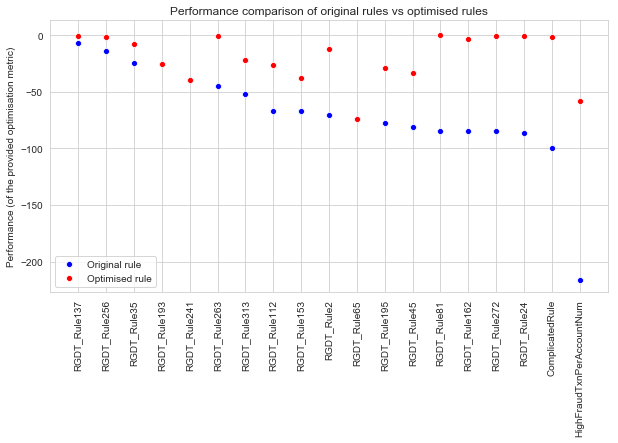

In [ ]:
ro.plot_performance_uplift(
    orig_rule_performances=ro.orig_rule_performances,
    opt_rule_performances=ro.opt_rule_performances,
    figsize=(10, 5)
)

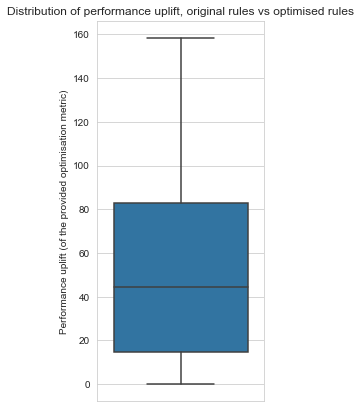

In [ ]:
ro.plot_performance_uplift_distribution(
    orig_rule_performances=ro.orig_rule_performances,
    opt_rule_performances=ro.opt_rule_performances,
    figsize=(3, 7)
)

### On the test set

To visualise the uplift on the test set, we first need to generate the *orig_rule_performances* and *opt_rule_performances* parameters used in the plotting methods as these aren't created as part of the optimisation process. To do this, we need to apply both the original rules and the optimised rules to the test set. **Note that before we apply the original rules, we need to remove those that either have no optimisable conditions, have zero variance features or have features that are missing in *X_train*:**

In [ ]:
# Original rules
rules_to_exclude = ro.rule_names_missing_features + ro.rule_names_no_opt_conditions + ro.rule_names_zero_var_features
rules.filter_rules(exclude=rules_to_exclude)
orig_sys_rule_strings = rules.as_rule_strings(as_numpy=False)
orig_ra = RuleApplier(
    rule_strings=orig_sys_rule_strings, 
    opt_func=apd.fit
)
_ = orig_ra.transform(X=X_test)
orig_rule_performances_test = orig_ra.rule_descriptions['OptMetric']

In [ ]:
# Optimised rules
_ = ro.transform(X=X_test)
opt_rule_performances_test = ro.rule_descriptions['OptMetric']

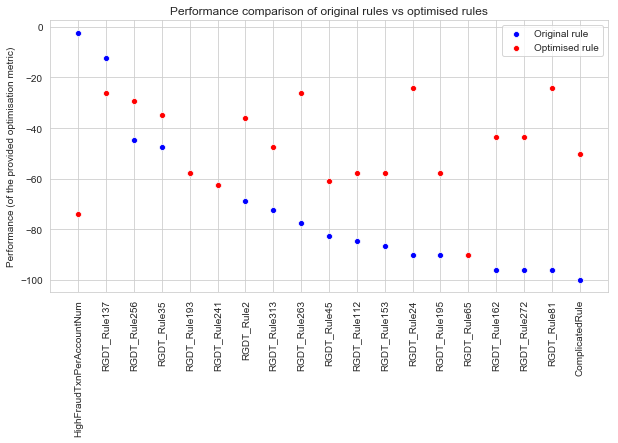

In [ ]:
ro.plot_performance_uplift(
    orig_rule_performances=orig_rule_performances_test,
    opt_rule_performances=opt_rule_performances_test,
    figsize=(10, 5)
)

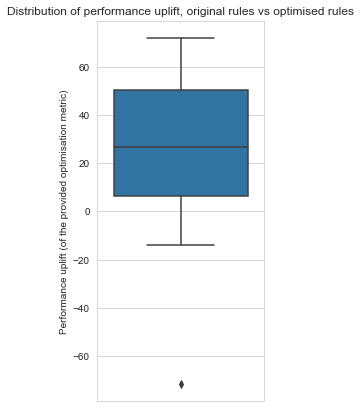

In [ ]:
ro.plot_performance_uplift_distribution(
    orig_rule_performances=orig_rule_performances_test,
    opt_rule_performances=opt_rule_performances_test,
    figsize=(3, 7)
)

----